Project root added to sys.path: d:\Handwritten Digit Recognition
Epoch 1/3
32/32 - 7s - 217ms/step - accuracy: 0.5725 - loss: 1.6456
Epoch 2/3
32/32 - 3s - 94ms/step - accuracy: 0.9193 - loss: 0.2872
Epoch 3/3
32/32 - 3s - 97ms/step - accuracy: 0.9645 - loss: 0.1330
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

 Test Accuracy: 0.9062
⏱ Training time: 13.09 sec
⏱ Prediction time: 2.98 sec

 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       1.00      0.87      0.93      1135
           2       0.93      0.90      0.91      1032
           3       0.76      0.98      0.85      1010
           4       0.98      0.89      0.93       982
           5       0.97      0.84      0.90       892
           6       0.95      0.94      0.94       958
           7       0.97      0.85      0.91      1028
           8       0.73      0.93      0.82       974
           9       0.94      0.90      0.92    

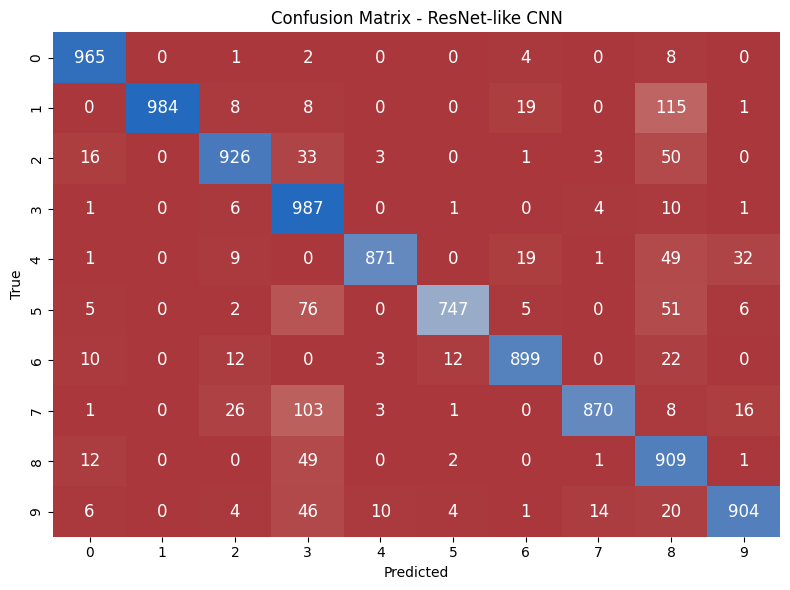

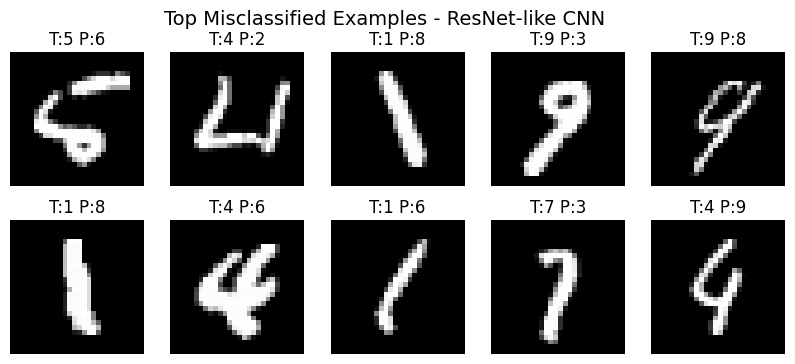

In [8]:
%run ../utils/init_notebook.py

from utils.data_loader import load_mnist
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Load data (raw pixels, no normalization)
X_train, y_train, X_test, y_test = load_mnist(normalise=False)

# Use smaller subset for faster training
subset_size = 4000
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

# Reshape for CNN input
X_train_cnn = X_train_sub.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train_sub, 10)
y_test_cat = to_categorical(y_test, 10)

# Define a simple residual block
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Build ResNet-like model
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 32, stride=2)  # downsample
x = resnet_block(x, 32)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
start_train = time.time()
model.fit(X_train_cnn, y_train_cat, epochs=3, batch_size=128, verbose=2)
end_train = time.time()

# Predict
start_pred = time.time()
y_pred_prob = model.predict(X_test_cnn)
y_pred_resnet = np.argmax(y_pred_prob, axis=1)
end_pred = time.time()

acc_resnet = accuracy_score(y_test, y_pred_resnet)
print(f"\n Test Accuracy: {acc_resnet:.4f}")
print(f"⏱ Training time: {end_train - start_train:.2f} sec")
print(f"⏱ Prediction time: {end_pred - start_pred:.2f} sec")

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_resnet))

# Confusion matrix
cm_resnet = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="vlag_r", cbar=False, annot_kws={"size": 12})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet-like CNN")
plt.tight_layout()
plt.show()

# Show misclassified examples
misclassified_idx_resnet = np.where(y_pred_resnet != y_test)[0]
plt.figure(figsize=(10, 4))
for i, idx in enumerate(misclassified_idx_resnet[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"T:{y_test[idx]} P:{y_pred_resnet[idx]}")
    plt.axis('off')
plt.suptitle("Top Misclassified Examples - ResNet-like CNN", fontsize=14)
plt.show()
